# 如何提取外轮廓

下面给你一套“从散点里把最外圈点抠出来，并画出尽量贴合的外轮廓”的常用武器库。你可以把它理解成：从“橡皮筋套住一堆豆子”（凸包）到“保鲜膜紧贴形状”（凹包/α-shape），再到“把豆子先变成像素再描边”（栅格化轮廓）。

**0) 先说结论：你最可能想要的是 凹包（Concave Hull / Alpha Shape）**

- 凸包：稳定、快，但会把凹陷“抹平”，不够贴合。(测试可以)
- α-shape（凹包）：能贴合凹陷，是“尽可能贴合数据”的主力。（不咋好用）
- 栅格化+等值线：如果点云很密且你想要“视觉上的外轮廓”（尤其有孔洞、裂缝），它非常好用。（测试可以）
- KNN凹包：另一种“可控贴合”的凹包实现方式，适合你想更几何地控制边界。（不咋好用）

-----------------------------

In [43]:
import pandas as pd  
import matplotlib.pyplot as plt  

In [41]:
# df = pd.read_csv('moving.csv', sep=',') 
# df = pd.read_csv('32capang.sm.pos.xls', sep='\t')
df = pd.read_csv('s79.txt', sep='\t')

df.head() 

,x,y,nGenes,nUMI,sid,3D_x,3D_y,3D_z,annotation,cid,index,sample
0,2872.011792,12724.749410,749,3428,s79,541.546343,1106.0,-3489.020864,Epi,DP8400016191TL_E3,s79_cell57_254,s79
1,2927.831254,12024.994652,717,3569,s79,-119.171426,1106.0,-3251.903671,Vm2,DP8400016191TL_E3,s79_cell58_240,s79
2,3024.120575,12925.098820,1024,5893,s79,774.737043,1106.0,-3394.686006,Vm (comp.),DP8400016191TL_E3,s79_cell60_258,s79
3,3224.350919,11923.667466,603,2426,s79,-139.312594,1106.0,-2939.197028,Vm2,DP8400016191TL_E3,s79_cell64_238,s79
4,3277.203497,11824.032867,698,2757,s79,-221.629653,1106.0,-2862.097418,Endo (V),DP8400016191TL_E3,s79_cell65_236,s79


In [42]:
points = df[['x', 'y']].values
pts = points 

------------------

## 1) 方法1：凸包（Convex Hull） 作为 baseline

- 适用：你只需要一个外框，允许不贴合凹陷。
- 优点：简单、快、稳定
- 缺点：凹进去的地方全被“拉直”


In [4]:
import numpy as np
from scipy.spatial import ConvexHull

In [31]:
def convex_boundary(pts):
    """
    输入:
      pts: (N, 2) ndarray

    输出:
      boundary_pts: (M, 2)，按顺序围一圈（闭合）
      boundary_idx: (M,)，对应原始 pts 的索引
    """
    pts = np.asarray(pts, float)
    hull = ConvexHull(pts)
    idx = hull.vertices           # 已经按顺/逆时针排序
    boundary = pts[idx]
    # 闭合一下
    boundary = np.vstack([boundary, boundary[0]])
    return boundary, idx



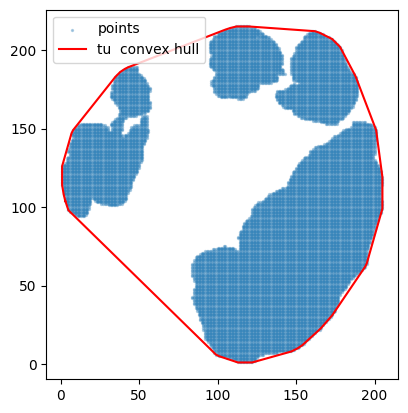

In [34]:
boundary, idx = convex_boundary(pts)

plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.3, label="points")
plt.plot(boundary[:,0], boundary[:,1], "r-", lw=1.5, label="tu  convex hull")
plt.gca().set_aspect("equal", adjustable="box")
plt.legend()
plt.show()

---------------------------------

## 2) 方法2：栅格化凹包：更贴合散点的外轮廓 

**1. 思路：栅格化 + 形态学 + 等值线 = 凹一点的外轮廓**

步骤很简单：

- 把所有点落到一个二维网格上（occupancy map）
- 对这个二值图做一点 closing / 高斯平滑，填掉小空洞、让轮廓顺一点
- 用 skimage.measure.find_contours 找等值线
- 取最长那条等值线，当成“最外层轮廓”
- （可选）用 KDTree 把这条轮廓上的点映射回原始散点，得到“外圈散点子集”

这样出来的轮廓会比凸包凹进去很多，在你那块“船形”数据上，会比较贴着下方的缺口和上边缘走。

**为啥会自动舍弃离群点？**

回顾一下栅格化流程里几个关键动作：

**1.散点 → 二值网格 mask**

- 主体那块是一大团相邻的 1
- 很远的离群点只是一两个孤立的 1 像素小岛

**2.形态学 closing + 高斯平滑**

- 主体区域变得更“饱满”
- 那些孤立的小岛，平滑后强度会被摊得很弱，或者仍然是很小的一团

**3.find_contours(img, level=0.5) 找等值线**

- 主体那块会产生一条很长的轮廓
- 每个离群小岛顶多产生一条很短的小圈圈

**4.max(contours, key=len) 只取最长那一条**

- 这一步直接把所有“小圈圈”（离群点）丢掉，只保留主体那圈

**所以你看到的效果是：**
- 原始散点图里还能看到几个飞出去的点
- 但画出的 concave boundary 完全不理它们，紧紧贴着中间那坨点走

这就是“栅格化方法自带的离群点过滤”。

In [8]:
# 从散点 → 外轮廓（连续曲线）
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.morphology import binary_closing, disk
from skimage.measure import find_contours

In [9]:
def concave_boundary_raster(pts,
                            pixel=None,      # 像素大小；None 时自动估计
                            pad=10,          # 边缘留白（像素）
                            close_r=3,       # 形态学闭运算半径
                            sigma=1.5,       # 高斯平滑 sigma
                            level=0.5):      # 等值线阈值
    """
    输入:
      pts   : (N, 2) 的散点坐标
    输出:
      boundary: (M, 2) 的轮廓坐标（按顺序围一圈）
    """
    pts = np.asarray(pts, float)
    x, y = pts[:, 0], pts[:, 1]

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # 自动估计像素大小: 把长边大约分成 400 像素
    if pixel is None:
        span = max(xmax - xmin, ymax - ymin)
        pixel = span / 400.0   # 400 可以自己调，大一点更平滑，小一点更贴

    # 网格尺寸
    W = int(np.ceil((xmax - xmin) / pixel)) + 1 + 2 * pad
    H = int(np.ceil((ymax - ymin) / pixel)) + 1 + 2 * pad

    # 1) 落点成二值图
    mask = np.zeros((H, W), dtype=bool)
    ix = np.round((x - xmin) / pixel).astype(int) + pad
    iy = np.round((y - ymin) / pixel).astype(int) + pad
    mask[iy, ix] = True

    # 2) 形态学闭运算填小空洞
    if close_r > 0:
        mask = binary_closing(mask, disk(close_r))

    # 3) 高斯平滑
    img = mask.astype(float)
    if sigma and sigma > 0:
        img = gaussian_filter(img, sigma=sigma)

    # 4) 找等值线
    contours = find_contours(img, level=level)
    if not contours:
        return None

    # 取最长的一条作为外轮廓
    max_c = max(contours, key=len)   # shape (M,2)，c[:,0]=row(y)，c[:,1]=col(x)
    
    # 所有轮廓, 映射回原始坐标系 
    all_boundaries = []
    for c in contours:
        boundary_i = np.column_stack([
            (c[:, 1] - pad) * pixel + xmin,
            (c[:, 0] - pad) * pixel + ymin,
        ])
        all_boundaries.append(boundary_i)  

    # 映射回原始坐标系
    boundary = np.column_stack([
        (max_c[:, 1] - pad) * pixel + xmin,
        (max_c[:, 0] - pad) * pixel + ymin,
    ])
    return boundary, all_boundaries 


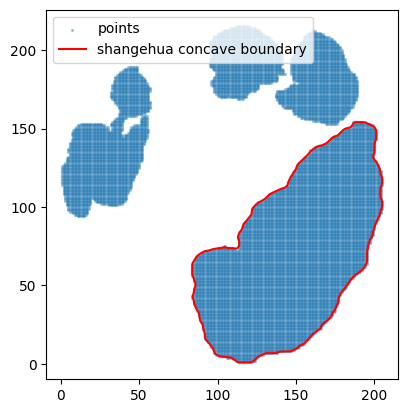

In [39]:
boundary, all_boundaries = concave_boundary_raster(pts, pixel=None, close_r=3, sigma=2.0)

plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.3, label='points')
if boundary is not None:
    plt.plot(boundary[:,0], boundary[:,1], 'r-', lw=1.5, label='shangehua concave boundary')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


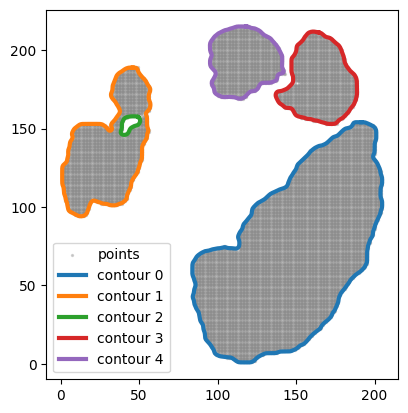

In [40]:
# 可视化全部的contours 
plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.3, label='points', c='gray') 

for i, c in enumerate(all_boundaries):
    plt.plot(c[:,0], c[:,1], lw=3.0, label=f'contour {i}')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
    

**调参建议（按照你这块数据的量级）：**
- 先不填 pixel，让函数自动估一个（长边约 400 像素）
- 看结果不够贴合，就减小一点：

boundary = concave_boundary_raster(pts, pixel=(x.max()-x.min())/600)


**下边那个凹进去的“缺口”如果被填平，说明 close_r / sigma 太大，可以减小：**
- close_r = 1~2
- sigma = 0.5~1.0

In [13]:
# 可选：把轮廓映射回“原始散点”的外圈点 
# 如果你真的想要的是：“这些就是散点中最外一圈的点”，可以再把轮廓上的连续点映射到最近的原始点上： 

from scipy.spatial import cKDTree

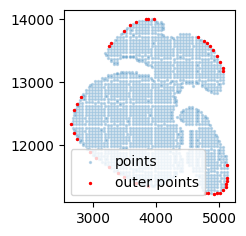

In [14]:
tree = cKDTree(pts)
dist, idx = tree.query(boundary, k=1)  # 每个轮廓点找最近的散点
outer_pts = pts[np.unique(idx)]       # 去重后，就是“外圈散点子集”

plt.figure(figsize=(4,2.5))
plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.25, label='points')
plt.scatter(outer_pts[:,0], outer_pts[:,1],s=2, c='r', label='outer points')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

**这样你就有两种对象可以用：**

- boundary：一条平滑、连续、贴合的外轮廓曲线
- outer_pts：原始散点里最外层那一圈点（可以拿去做别的分析）

-------------------------

## 3) 方法3：先去除离群点，再计算凹包/凸包  

好，这一招就是给“栅格化凹包”加一个预处理滤网：
先把飞出去的点捞掉，再去做栅格化凹包，轮廓会稳很多，也不会被几个孤儿点拉出奇怪的触角 🪄

下面我给你一整套：
- 用 DBSCAN 自动去除离群点
- 在干净的点上做栅格化凹包
- 统一一个高层函数方便调用

**步骤一：用 DBSCAN 去离群点**

思路：

利用点之间的局部密度，把“主团”点找出来

自动估一个 eps（邻域半径），减少你手动瞎调

保留 DBSCAN 里最大簇作为主体形状

In [15]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [16]:
def remove_outliers_dbscan(
    pts,
    eps=None,
    min_samples=5,
    k=4,
    quantile=0.95,
    eps_factor=1.5,
):
    """
    用 DBSCAN 去除离群点：只删噪声(label = -1)，保留所有簇。

    参数
    ----
    pts : (N,2) ndarray
    eps : 邻域半径；None 则自动估计
    min_samples : DBSCAN 的 min_samples
    k : 用第 k 近邻来估计 eps
    quantile : 用第 k 近邻距离的这个分位数作为基准
    eps_factor : 再乘一个放大系数，避免 eps 太小

    返回
    ----
    clean_pts : (M,2) 去掉噪声点后的点
    mask      : (N,) bool，True 表示保留下来的点
    """
    pts = np.asarray(pts, float)
    n = len(pts)
    if n == 0:
        return pts, np.zeros(0, dtype=bool)

    # 1) 自动估 eps
    if eps is None:
        k = min(k, max(2, n - 1))
        nbrs = NearestNeighbors(n_neighbors=k).fit(pts)
        dists, _ = nbrs.kneighbors(pts)
        kth = dists[:, -1]                     # 每个点到第 k 近邻的距离
        base_eps = np.quantile(kth, quantile)  # 比如 95% 分位
        eps = base_eps * eps_factor
        if eps <= 0:
            eps = np.max(kth) or 1.0

    # 2) DBSCAN 聚类
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(pts)

    # 3) 只删 label = -1 的噪声，其余全部保留
    mask = labels != -1
    clean_pts = pts[mask]
    return clean_pts, mask


In [17]:
def concave_boundary_denoised(pts,
                              # 去噪相关
                              eps=None,
                              min_samples=5,
                              k=4,
                              quantile=0.95,
                              eps_factor=1.5,
                              # 凹包相关
                              pixel=None,
                              pad=10,
                              close_r=3,
                              sigma=1.5,
                              level=0.5):
    pts = np.asarray(pts, float)

    # 1) 去离群点（新版本）
    clean_pts, mask = remove_outliers_dbscan(
        pts,
        eps=eps,
        min_samples=min_samples,
        k=k,
        quantile=quantile,
        eps_factor=eps_factor,
    )
    if len(clean_pts) < 3:
        return None, clean_pts, mask

    # 2) 对干净点做栅格化凹包
    boundary = concave_boundary_raster(
        clean_pts,
        pixel=pixel,
        pad=pad,
        close_r=close_r,
        sigma=sigma,
        level=level,
    )
    return boundary, clean_pts, mask


In [18]:
boundary, clean_pts, mask = concave_boundary_denoised(
    pts,
    # 去噪
    min_samples=5,
    k=4,
    quantile=0.95,
    eps_factor=1.5,
    # 凹包
    pixel=None,
    close_r=2,
    sigma=1.5,
)
print(pts.shape, "->", clean_pts.shape)

(1872, 2) -> (1872, 2)


C:\Users\13554\AppData\Local\Temp\ipykernel_31728\3069541382.py:36: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  mask = binary_closing(mask, disk(close_r))


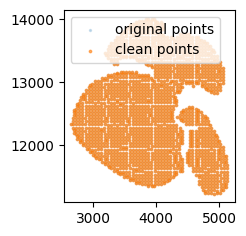

In [19]:
# 绘图  
plt.figure(figsize=(4,2.5))
plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.2, label="original points")
plt.scatter(clean_pts[:,0], clean_pts[:,1], s=3, alpha=0.6, label="clean points")
if boundary is not None:
    plt.plot(boundary[:,0], boundary[:,1], "r-", lw=1.5, label="concave boundary")
plt.gca().set_aspect("equal", adjustable="box")
plt.legend()
plt.show()


In [20]:
from scipy.spatial import cKDTree
boundary = concave_boundary_raster(pts, pixel=None, close_r=3, sigma=2.0)  
# boundary: 上面函数得到的 (M,2)
tree = cKDTree(pts)
dist, idx = tree.query(boundary, k=1)  # 每个轮廓点找最近的散点
outer_pts = pts[np.unique(idx)]       # 去重后，就是“外圈散点子集”

plt.figure(figsize=(4,2.5))
plt.scatter(pts[:,0], pts[:,1], s=1, alpha=0.25, label='points')
plt.scatter(outer_pts[:,0], outer_pts[:,1], s=1, c='r', label='outer points')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


C:\Users\13554\AppData\Local\Temp\ipykernel_31728\3069541382.py:36: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  mask = binary_closing(mask, disk(close_r))


ValueError: x must consist of vectors of length 2 but has shape (1,)

---------------------
## 4) 方法4：凹包（Alpha Shape / Concave Hull） 最贴合的主力

这是个好问题，而且你这段代码其实就是「教科书级」的 α-shape 实现本体，只是你把它自己写出来了而我前面直接用库糊过去了 😅

前面我说的 “alpha shape / 凹包” 方法，本质上就是你这套：

`Delaunay 三角剖分 → 按外接圆半径过滤三角形 → 把保留的三角形 union 成一个区域`

alphashape.alphashape 这种库，底层就是类似的实现，所以我之前没有再从头把 Delaunay 版本展开写一遍。

In [13]:
from scipy.spatial import Delaunay, ConvexHull
from shapely.ops import polygonize, unary_union
from shapely.geometry import MultiPoint, Polygon, MultiPolygon, GeometryCollection, LineString


In [14]:
def alpha_shape(points, alpha):
    """
    计算凹包（alpha shape）
    使用 Delaunay 三角剖分 + 外接圆半径过滤
    返回 Shapely 几何对象（Polygon / MultiPolygon / GeometryCollection）
    """
    points = np.asarray(points, float)
    if len(points) < 4:
        return MultiPoint(points).convex_hull

    def circumradius(triangle_points):
        a, b, c = triangle_points
        a_len = np.linalg.norm(c - b)
        b_len = np.linalg.norm(c - a)
        c_len = np.linalg.norm(b - a)
        s = (a_len + b_len + c_len) / 2.0
        area = np.sqrt(max(s * (s - a_len) * (s - b_len) * (s - c_len), 0.0))
        if area < 1e-10:
            return float("inf")
        return a_len * b_len * c_len / (4.0 * area)

    tri = Delaunay(points)

    polys = []
    inv_alpha = 1.0 / alpha
    for simplex in tri.simplices:
        tri_pts = points[simplex]
        r = circumradius(tri_pts)
        if r < inv_alpha:           # alpha 越大，凹得越狠
            polys.append(Polygon(tri_pts))

    if not polys:
        return MultiPoint(points).convex_hull

    try:
        geom = unary_union(polys)
    except Exception:
        geom = MultiPoint(points).convex_hull
    return geom


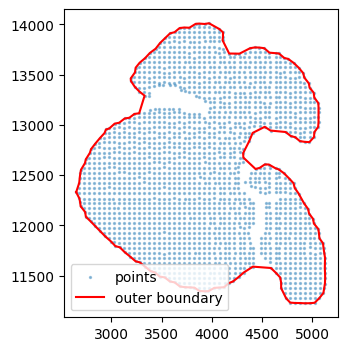

In [26]:
poly = alpha_shape(pts, alpha=0.01)  # alpha 可调
bx, by = poly.exterior.xy    # 外边界坐标
boundary_pts = np.column_stack([bx, by])  # 已经是按顺序的一圈
# 画图看看
plt.figure(figsize=(4,4))
plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.4, label="points")
plt.plot(bx, by, "r-", lw=1.5, label="outer boundary")
plt.gca().set_aspect("equal", adjustable="box")
plt.legend()
plt.show()

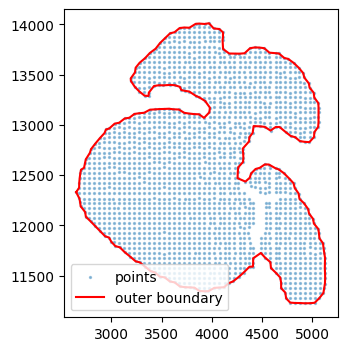

In [27]:
poly = alpha_shape(pts, alpha=0.02)  # alpha 可调
bx, by = poly.exterior.xy    # 外边界坐标
boundary_pts = np.column_stack([bx, by])  # 已经是按顺序的一圈
# 画图看看
plt.figure(figsize=(4,4))
plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.4, label="points")
plt.plot(bx, by, "r-", lw=1.5, label="outer boundary")
plt.gca().set_aspect("equal", adjustable="box")
plt.legend()
plt.show()

**在你这个实现上可以做的几处改进** 
处理 GeometryCollection，只拿最大 Polygon 的外轮廓

你现在：
```
alpha_shape = unary_union(triangles)
return alpha_shape
```

这一步非常可能返回：

- Polygon
- 或 MultiPolygon
- 或 GeometryCollection

可以加一层包装，直接返回最外层轮廓坐标（而不是裸几何），也顺便把 GeometryCollection 吃掉：

In [16]:
def alpha_shape_polygon(points, alpha):
    """
    在你原有 alpha_shape() 的基础上，
    保证最终返回的是一个 Polygon（取面积最大那块）。
    """
    geom = alpha_shape(points, alpha)  # 这里调用的是你上面的函数
    pts = np.asarray(points, float)

    # 如果本来就是 Polygon，直接返回
    if isinstance(geom, Polygon):
        return geom

    # 如果是 MultiPolygon，取面积最大的一块
    if isinstance(geom, MultiPolygon):
        if not geom.geoms:
            return MultiPoint(pts).convex_hull
        return max(geom.geoms, key=lambda g: g.area)

    # 如果是 GeometryCollection，挑里面的 Polygon 再取最大
    if isinstance(geom, GeometryCollection):
        polys = [g for g in geom.geoms if isinstance(g, Polygon)]
        if polys:
            return max(polys, key=lambda g: g.area)
        # 没有面，就退回凸包
        return MultiPoint(pts).convex_hull

    # 其它类型，直接退回凸包
    return MultiPoint(pts).convex_hull


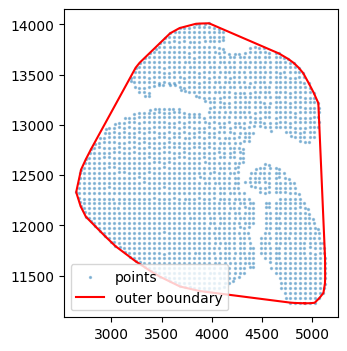

In [17]:
poly = alpha_shape_polygon(pts, alpha=0.5)
bx, by = poly.exterior.xy

boundary_pts = np.column_stack([bx, by])  # 已经是按顺序的一圈
# 画图看看
plt.figure(figsize=(4,4))
plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.4, label="points")
plt.plot(bx, by, "r-", lw=1.5, label="outer boundary")
plt.gca().set_aspect("equal", adjustable="box")
plt.legend()
plt.show()

**加一个“auto-alpha 往外搜”的小助手**

- 你之前被 GeometryCollection 卡住，本质上是 alpha 选得太激进（太大），
- 我们可以在你这版实现上，加一段“从松到紧”自动搜索的逻辑：

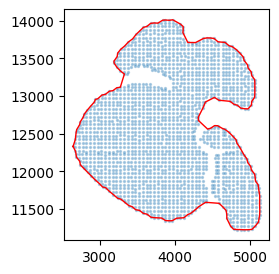

In [18]:
def alpha_shape_until_polygon(points,
                              alpha_start,
                              factor=1.5,
                              max_iter=10):
    """
    从一个 alpha 起步，每次乘 factor 变大，
    直到得到一个 Polygon 为止；失败就退回凸包。
    """
    pts = np.asarray(points, float)
    geom = None
    alpha = alpha_start

    for _ in range(max_iter):
        geom = alpha_shape(pts, alpha)
        # 尝试提取 polygon
        poly = alpha_shape_polygon(pts, alpha)
        if poly.geom_type == "Polygon":
            return poly, alpha
        alpha *= factor  # 让形状更凹一点

    # 如果始终不稳定，就退回凸包
    return MultiPoint(pts).convex_hull, None

poly, alpha_used = alpha_shape_until_polygon(points, alpha_start=0.01)
boundary = np.column_stack(poly.exterior.xy) 
plt.figure(figsize=(4,3))
plt.scatter(points[:,0], points[:,1], s=2, alpha=0.3)
plt.plot(boundary[:,0], boundary[:,1], 'r-', lw=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

----

In [19]:
def alpha_shape_algo(points, alpha):
    """
    方法二 
    凹包算法 
    Robust alpha shape (concave hull) using Delaunay + circumradius filter + boundary edges polygonize.
    alpha: >0, larger -> tighter if using radius < 1/alpha (keep your convention).
    Returns: contour points (N,2) ordered, not closed (no repeated first/last).
    你这版 alpha_shape_algo，跟前面那种“把所有小三角形 unary_union 成一个面”的写法相比，确实是一次比较漂亮的升级;
    功能一样是“凹包”，但版本升级成了「更稳、更干净、直接给轮廓坐标」的专业版。
    """

    points = np.asarray(points, dtype=float)
    if points.ndim != 2 or points.shape[1] != 2:
        raise ValueError("points must be (N,2) array")

    if len(points) < 4 or alpha is None or alpha <= 0:
        hull = MultiPoint(points).convex_hull
        return np.asarray(hull.exterior.coords)[:-1]

    def circumradius(tri_pts):
        a, b, c = tri_pts
        ab = np.linalg.norm(b - a)
        bc = np.linalg.norm(c - b)
        ca = np.linalg.norm(a - c)
        s = (ab + bc + ca) / 2.0
        area2 = s * (s - ab) * (s - bc) * (s - ca)
        if area2 <= 1e-20:
            return np.inf
        area = np.sqrt(area2)
        return (ab * bc * ca) / (4.0 * area)

    tri = Delaunay(points)

    # collect boundary edges from kept triangles
    edge_count = {}
    def add_edge(i, j):
        if i > j:
            i, j = j, i
        edge_count[(i, j)] = edge_count.get((i, j), 0) + 1

    thresh = 1.0 / alpha
    for simplex in tri.simplices:
        tri_pts = points[simplex]
        if circumradius(tri_pts) < thresh:
            add_edge(simplex[0], simplex[1])
            add_edge(simplex[1], simplex[2])
            add_edge(simplex[2], simplex[0])

    boundary_edges = [e for e, c in edge_count.items() if c == 1]
    if not boundary_edges:
        hull = MultiPoint(points).convex_hull
        return np.asarray(hull.exterior.coords)[:-1]

    lines = [LineString([points[i], points[j]]) for i, j in boundary_edges]
    polys = list(polygonize(unary_union(lines)))

    if not polys:
        hull = MultiPoint(points).convex_hull
        return np.asarray(hull.exterior.coords)[:-1]

    # choose the largest polygon as the outer boundary
    poly = max(polys, key=lambda p: p.area)
    coords = np.asarray(poly.exterior.coords)[:-1]  # drop closing point
    return coords


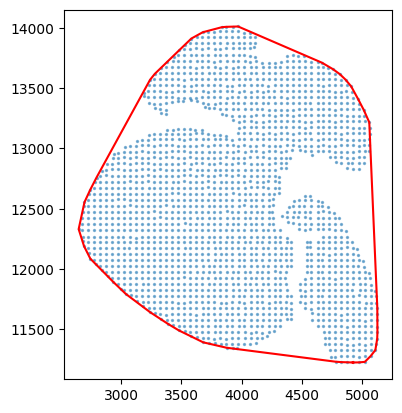

In [21]:
poly = alpha_shape_algo(pts, alpha=1)  
poly_closed = np.vstack([poly, poly[0]])

plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.5, label='points')
plt.plot(poly_closed[:,0], poly_closed[:,1], 'r-', lw=1.5, label='alpha shape contour')
plt.gca().set_aspect('equal', adjustable='box')

------------------------------- 

**对于多边形，找出所有的poly**  

In [ ]:
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection, MultiPoint


In [28]:
def alpha_shape_all_polys(points, alpha, min_area=0.0):
    """
    在你已有的 alpha_shape() 基础上：
    - 提取出所有 Polygon
    - 可选：按面积过滤
    - 返回 Polygon 列表和每个 polygon 的边界坐标

    返回:
      polys      : [Polygon, ...]，已按面积从大到小排序
      boundaries : [ndarray(M_i,2), ...] 每个 polygon 的外轮廓坐标
    """
    pts = np.asarray(points, float)
    geom = alpha_shape(pts, alpha)  # 这里用的就是你上面的函数

    polys = []

    if isinstance(geom, Polygon):
        polys = [geom]

    elif isinstance(geom, MultiPolygon):
        polys = list(geom.geoms)

    elif isinstance(geom, GeometryCollection):
        # 只要里面的 Polygon
        polys = [g for g in geom.geoms if isinstance(g, Polygon)]

    else:
        # 其他类型就退回凸包
        polys = [MultiPoint(pts).convex_hull]

    # 面积过滤 & 排序（可选）
    polys = [p for p in polys if p.area > min_area]
    polys.sort(key=lambda p: p.area, reverse=True)

    # 每个 polygon 的外轮廓坐标
    boundaries = []
    for poly in polys:
        x, y = poly.exterior.xy
        boundaries.append(np.column_stack([x, y]))   # (M_i, 2)

    return polys, boundaries


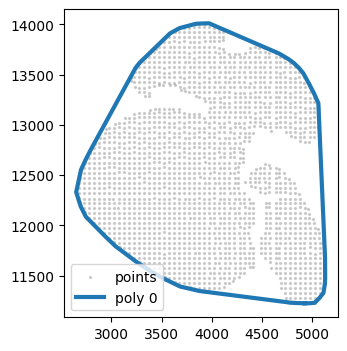

In [29]:
polys, boundaries = alpha_shape_all_polys(pts, alpha=0.5, min_area=50.0)

plt.figure(figsize=(4,4))
plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.3, label="points", c='gray')

for i, b in enumerate(boundaries):
    plt.plot(b[:,0], b[:,1], lw=3, label=f"poly {i}")

plt.gca().set_aspect("equal", adjustable="box")
plt.legend()
plt.show()


In [ ]:
# 输出”为数组 / 字典

result = {
    i: {
        "area": polys[i].area,
        "boundary": boundaries[i],   # ndarray
    }
    for i in range(len(polys))
}

(np.float64(77.95), np.float64(211.05), np.float64(-6.65), np.float64(161.65))

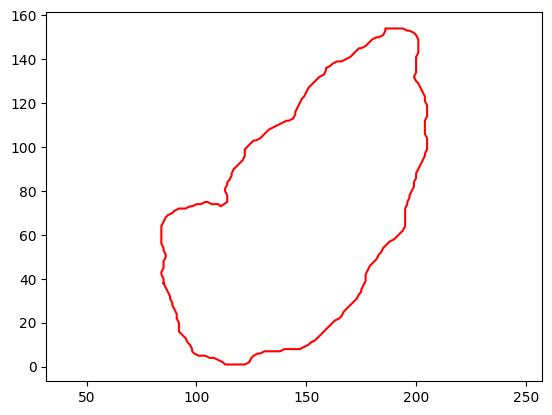

In [ ]:
plt.plot(result[0]['boundary'][:,0], result[0]['boundary'][:,1], 'r-')  
plt.axis('equal') 

In [ ]:
# 给每个点一个“所属 poly 的编号”（类似 cluster id） 

from shapely.geometry import Point
from shapely.prepared import prep

pts = np.asarray(pts, float)
labels = np.full(len(pts), -1, dtype=int)  # -1 表示不在任何 poly 内

for pid, poly in enumerate(polys):
    ppoly = prep(poly)  # prepared geometry 加速 contains 判定
    mask = []
    for x, y in pts:
        mask.append(ppoly.contains(Point(x, y)) or ppoly.touches(Point(x, y)))
    mask = np.array(mask, dtype=bool)
    labels[mask] = pid


In [ ]:
len(labels) 

17788

In [ ]:
set(labels) 

{np.int64(0), np.int64(1), np.int64(2), np.int64(3)}

----------------------------
## 5) 方法5：KNN 凹包（Concave Hull by k-nearest neighbors）

适用：你希望控制“边界有多凹”，并且希望输出就是一圈按序的边界点（“最外层点”感觉更强）。

参数：k

k 小：更凹、更贴合，但更容易自交、断裂

k 大：更平滑，趋向凸包

实现一般用现成实现或自己写（算法叫 Moreira & Santos concave hull）。如果你告诉我你点的规模（N大概多少）我可以给你一个稳定版本（带自交修复、断裂处理、外点剔除）。

In [ ]:
try:
    import alphashape
    from shapely.geometry import Point
    ALPHASHAPE_AVAILABLE = True
except ImportError:
    ALPHASHAPE_AVAILABLE = False
    print("提示: 安装 alphashape 库可获得更好的凹包效果: pip install alphashape")

In [ ]:
def find_boundary_points_knn(points, k=10):
    """
    使用k近邻方法找到边界点
    边界点定义：与其k近邻的平均距离大于阈值的点
    
    参数:
        points: 输入点云 (N, 2)
        k: 近邻数量
    返回:
        boundary_indices: 边界点的索引
    """
    from sklearn.neighbors import NearestNeighbors
    
    # 构建KNN模型
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='kd_tree').fit(points)
    distances, indices = nbrs.kneighbors(points)
    
    # 计算每个点到其k近邻的平均距离（排除自己）
    avg_distances = distances[:, 1:].mean(axis=1)
    
    # 边界点通常有更大的平均距离
    threshold = np.percentile(avg_distances, 85)  # 取前15%作为边界
    boundary_mask = avg_distances > threshold
    
    return np.where(boundary_mask)[0]


In [ ]:
def order_boundary_points(points):
    """
    将边界点按照逆时针顺序排列
    
    参数:
        points: 边界点 (N, 2)
    返回:
        ordered_points: 排序后的边界点
    """
    # 计算质心
    centroid = points.mean(axis=0)
    
    # 计算每个点相对于质心的角度
    angles = np.arctan2(points[:, 1] - centroid[1], 
                       points[:, 0] - centroid[0])
    
    # 按角度排序
    sorted_indices = np.argsort(angles)
    
    return points[sorted_indices]

In [ ]:
def find_contour_points(points, n_points=50, use_concave=True, alpha=None):
    """
    提取点云的轮廓点（支持凹包和凸包）
    
    参数:
        points: 输入点云 (N, 2)
        n_points: 轮廓采样点数
        use_concave: 是否使用凹包，默认True
        alpha: alpha shape参数。None表示自动计算最优alpha
    返回:
        contour_points: 轮廓点 (n_points, 2)
    """
    try:
        if use_concave:
            # 方法1: 使用k近邻提取边界点
            print(f"  使用凹包算法（KNN边界检测）提取轮廓...")
            
            # 找到边界点
            boundary_indices = find_boundary_points_knn(points, k=min(15, len(points)//10))
            boundary_points = points[boundary_indices]
            
            # 按顺序排列边界点
            ordered_boundary = order_boundary_points(boundary_points)
            
            # 如果有alphashape库，可以进一步优化
            if ALPHASHAPE_AVAILABLE and alpha is not None:
                try:
                    alpha_shape = alphashape.alphashape(points, alpha)
                    if hasattr(alpha_shape, 'exterior'):
                        boundary_coords = np.array(alpha_shape.exterior.coords)
                        ordered_boundary = boundary_coords
                        print(f"  使用alpha shape优化 (alpha={alpha})")
                except:
                    pass  # 使用KNN结果
            elif ALPHASHAPE_AVAILABLE and alpha is None:
                # 自动优化alpha值
                try:
                    alpha_shape = alphashape.alphashape(points)
                    if hasattr(alpha_shape, 'exterior'):
                        boundary_coords = np.array(alpha_shape.exterior.coords)
                        ordered_boundary = boundary_coords
                        print(f"  使用alpha shape自动优化")
                except:
                    pass  # 使用KNN结果
            
            # 均匀采样
            n_boundary = len(ordered_boundary)
            if n_boundary < n_points:
                # 插值增加点
                indices = np.linspace(0, n_boundary-1, n_points, endpoint=False)
                indices_int = indices.astype(int)
                indices_frac = indices - indices_int
                
                contour_points = []
                for i, frac in zip(indices_int, indices_frac):
                    next_i = (i + 1) % n_boundary
                    pt = ordered_boundary[i] * (1 - frac) + ordered_boundary[next_i] * frac
                    contour_points.append(pt)
                contour_points = np.array(contour_points)
            else:
                indices = np.linspace(0, n_boundary, n_points, endpoint=False).astype(int)
                contour_points = ordered_boundary[indices]
            
            print(f"  凹包提取了 {len(contour_points)} 个轮廓点")
            
        else:
            # 使用传统凸包方法
            print(f"  使用凸包算法提取轮廓...")
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            
            # 按顺序排列凸包点并均匀采样
            n_hull = len(hull_points)
            if n_hull < n_points:
                indices = np.linspace(0, n_hull, n_points, endpoint=False).astype(int)
            else:
                indices = np.linspace(0, n_hull, n_points, endpoint=False).astype(int)
            
            contour_points = hull_points[indices]
            print(f"  凸包提取了 {len(contour_points)} 个轮廓点")
        
        return contour_points
        
    except Exception as e:
        print(f"  警告: 轮廓提取失败 ({e})，使用凸包作为备选方案")
        # 如果计算失败，使用凸包作为备选
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            n_hull = len(hull_points)
            indices = np.linspace(0, n_hull, min(n_points, n_hull), endpoint=False).astype(int)
            return hull_points[indices]
        except:
            # 最后的备选方案
            indices = np.linspace(0, len(points), min(n_points, len(points)), endpoint=False).astype(int)
            return points[indices]

  使用凹包算法（KNN边界检测）提取轮廓...
  使用alpha shape优化 (alpha=0.01)
  凹包提取了 100 个轮廓点


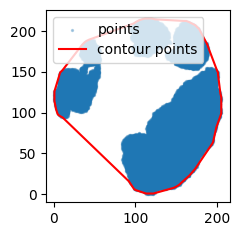

In [ ]:
# ===== 示例用法 =====
pts = points
contour_pts = find_contour_points(pts, n_points=100, use_concave=True, alpha=0.01)  
plt.figure(figsize=(4,2.5)) 
plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.3, label='points')
plt.plot(contour_pts[:,0], contour_pts[:,1], 'r-', lw=1.5, label='contour points')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


  使用凹包算法（KNN边界检测）提取轮廓...
  使用alpha shape优化 (alpha=0.01)
  凹包提取了 100 个轮廓点


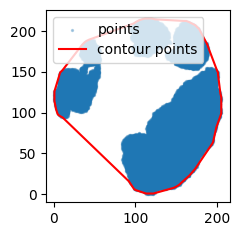

In [ ]:
pts = points
contour_pts = find_contour_points(pts, n_points=100, use_concave=True, alpha=0.01)    # 没有指定alpha参数的话，会非常耗时 
plt.figure(figsize=(4,2.5)) 
plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.3, label='points')
plt.plot(contour_pts[:,0], contour_pts[:,1], 'r-', lw=1.5, label='contour points')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

-------------- 
我建议你怎么选（按你的“尽可能贴合”需求）

一般情况：直接用 Alpha Shape（方法B），再配合一点离群点清理（方法E）

点非常密，想要像图像轮廓一样丝滑：用 栅格化+等值线（方法D）

你特别强调“最外层点集合”且想几何可控：用 KNN凹包（方法C）